#Tutorial: Deep Convolutional Neural Network (DCNN)
##Cloud Classification

* Author: James Harding
* email: jamesharding@live.co.uk | james.harding@ed.ac.uk
* License: MIT
* Repository: Github

---

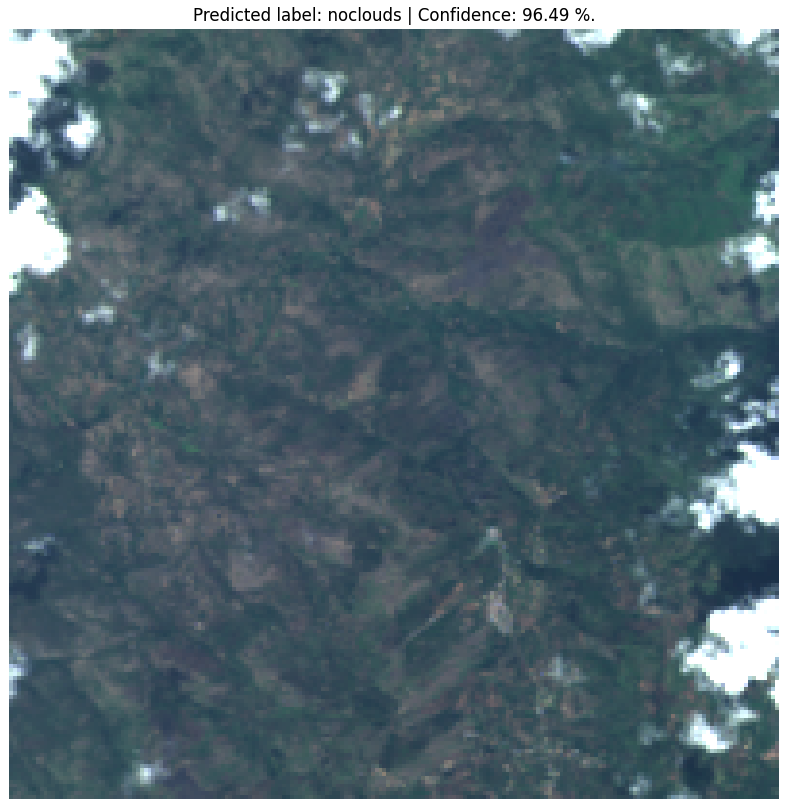

##Notebook Summary
Given a subset of satellite image data, this notebook develops a simple algorithm to determine if an image contains 'cloud' or 'noclouds'. The training data contains 7000 samples (3500:3500 clouds:noclouds). This set is split into Train:Val:Test sets using 60:20:20% of the data. Preprocessing of data (including augmentation) happens inside the network. The final model is a deep convolutional downsampling network with a densely connected head prior to output. The model contains ~500 parameters. This model achieves ~97% accuracy on the hold-out Test dataset (20% of available data).

This performance appears quite efficient. How does it compare to decision forrest methods?

##Code Cell Contents:

A. Preamble

    1. Authentication
    2. Libraries, Definitions & Packages
    3. Extract zip. files
    4. Directory summary statistics

B. Dataset splits and visualising

    5. Dataset splits
    6. Load datsets
    7. Visualise a dataset batch

C. Model Development & Saving  

    8. Custom Model Design
    9. Training Callbacks
    10. Model Training, Validation and Test
    11. Plots Training & Validation
    12. Model Saving

D. Model Serving   

    13. Demo – Model Loading & Inference


In [1]:
#@title 1. Authentication – Colab & Google Drive

# Cloud/colab authentication.
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title 2. Libraries, Definitions & Packages
import os
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
tfk  = tf.keras
tfkl = tf.keras.layers

import numpy as np
tp   = tf.math

import matplotlib.pyplot as plt

!pip install patool
import patoolib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.3 MB/s eta 0:00:00


2. Extract the contents of the zip file

In [13]:
#@title 4. Directory Summary Statistics

# Set the directory path to the dataset
data_dir = pathlib.Path("/content/drive/MyDrive/toy_data/clouds")


image_count = len(list(data_dir.glob('*/*.png')))
print('Total image count: ', image_count)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.png'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print('Class names: ', class_names)

for class_name in class_names:
    class_count = len(list(data_dir.glob(class_name + '/*.png')))
    print('Count for '+ class_name +': ', class_count)


Total image count:  7000
Class names:  ['clouds' 'noclouds']
Count for clouds:  3500
Count for noclouds:  3500


In [14]:
#@title 5. Dataset Splits – Train:Validation:Test 60:20:20%
test_size = int(np.floor(tf.data.experimental.cardinality(list_ds).numpy() * 0.2))

train_val_ds = list_ds.skip(test_size)
val_size = int(np.floor(tf.data.experimental.cardinality(train_val_ds).numpy() * 0.25))

train_ds = train_val_ds.skip(val_size)
val_ds   = train_val_ds.take(val_size)
test_ds = list_ds.take(test_size)

print('Total sample count: ', image_count)
print('Training sample count: ', tf.data.experimental.cardinality(train_ds).numpy())
print('Validation sample count: ', tf.data.experimental.cardinality(val_ds).numpy())
print('Test sample count: ', tf.data.experimental.cardinality(test_ds).numpy())

Total sample count:  7000
Training sample count:  4200
Validation sample count:  1400
Test sample count:  1400


In [15]:
#@title 6. Load Datasets
batch_size = 16
img_height = 200
img_width = 200

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) # Convert the path to a list of path components
    one_hot = parts[-2] == class_names # The second to last is the class-directory
    return tf.argmax(one_hot) # Integer encode the label
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3) # Convert the compressed string to a 3D uint8 tensor
    return tf.image.resize(img, [img_height, img_width]) # Resize the image to the desired size
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path) # Load the raw data from the file as a string
    img = decode_img(img)
    return img, label
def configure_for_performance(ds):
    ds = ds.cache()
    #ds = ds.shuffle(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)


Image shape:  (16, 200, 200, 3)
Label:  [0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1]
Image shape:  (16, 200, 200, 3)
Label:  [0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0]


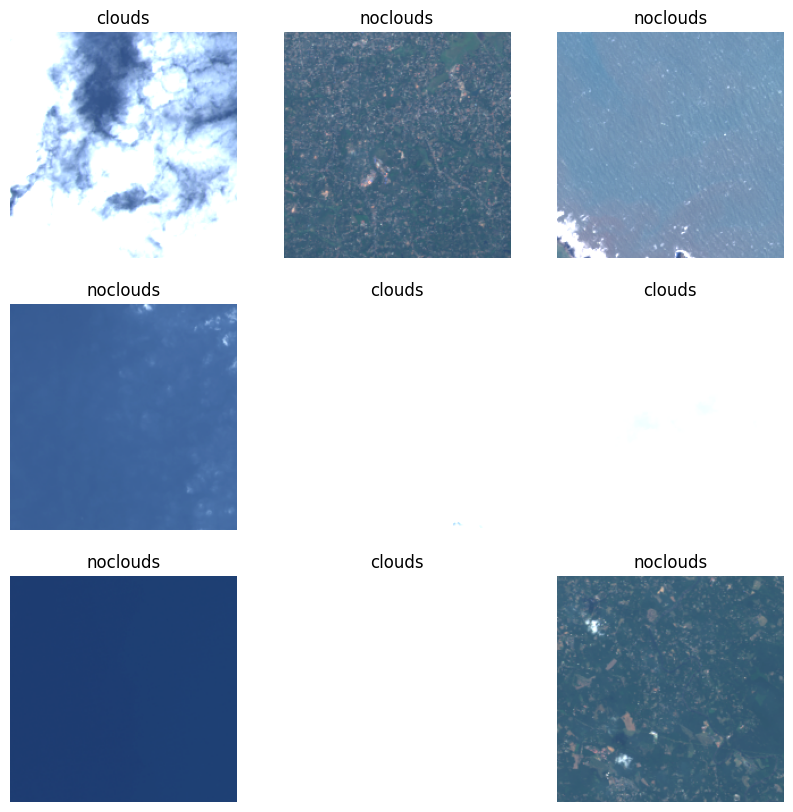

In [16]:
#@title 7. Visualise Data Batch

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [20]:
#@title 8. Custom Model – Cloud Classifier
class CloudClassifier(tfk.Model):

    def __init__(self, n_classes, **model_kwargs):
        super(CloudClassifier, self).__init__()
        self.n_classes  = n_classes

    def build(self, input_shape):

        # Define Model Subcomponents

        # 1. Input & preprocessing layers
        input_layer = tfkl.Input(shape=(input_shape[1], input_shape[2], 3), name='input_layer')
        prep_layer     =  [tfkl.Rescaling(1./255, name='preprocessing_layer')]

        # 2. Augmentation layers (training only)
        aug_layer      =  [tfkl.RandomFlip(),
                           tfkl.RandomBrightness(0.03, value_range=(0, 1)),
                           #tfkl.RandomContrast(0.03),
                           tfkl.RandomZoom(0.1, fill_mode='constant', interpolation='bilinear', fill_value=0.0),
                           tfkl.RandomRotation(0.1, fill_mode='constant', interpolation='bilinear', fill_value=0.0),
                           ]

        # 3. CNN Downsampling layers
        cnn_layer     =  [tfkl.Conv2D(2, (5,5), strides=(5, 5), padding="same", activity_regularizer=tfk.regularizers.L1L2(l1=0.0001, l2=0.0001), activation='gelu'), tfkl.MaxPooling2D(padding="same",),
                          tfkl.UpSampling2D((2, 2)),
                          tfkl.Conv2D(4, (5,5), strides=(5, 5), padding="same", activity_regularizer=tfk.regularizers.L1L2(l1=0.0001, l2=0.0001), activation='gelu'), tfkl.MaxPooling2D(padding="same",),
                          tfkl.UpSampling2D((2, 2)),
                          tfkl.Conv2D(8, (4,4), strides=(4, 4), padding="same", activity_regularizer=tfk.regularizers.L1L2(l1=0.0001, l2=0.0001), activation='gelu'), tfkl.MaxPooling2D(padding="same",),
                          tfkl.UpSampling2D((2, 2)),
                          tfkl.Conv2D(8, (4,4), strides=(4, 4), padding="same", activity_regularizer=tfk.regularizers.L1L2(l1=0.0001, l2=0.0001), activation='gelu'), tfkl.MaxPooling2D(padding="same",),
                          tfkl.Dropout(0.25)
                          ]
        # 4. Output layers
        flat_layer      =  tfkl.Flatten()
        dense_layer    =  tfkl.Dense(2, activation='gelu', activity_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001),)
        output_layer   =  tfkl.Dense(self.n_classes)

        # Build Model: 1->2->3->4
        self.model     =  tfk.Sequential([input_layer] + prep_layer + aug_layer + cnn_layer + [flat_layer] + [dense_layer] + [output_layer])

    # @tf.function(experimental_compile=True)
    def call(self, inputs):
        return self.model(inputs)
    def get_config(self):
        config = super(CloudClassifier, self).get_config()
        config.update({"n_classes": self.n_classes})
        return config

model = CloudClassifier(n_classes=2)
model.compile(optimizer='adam',
              loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
#@title 9. Training Callbacks – Early Stopping & Best Weights

class EarlyStoppingAtMinLoss(tfk.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=10):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        print("Loading best weights")
        self.model.set_weights(self.best_weights)
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [22]:
#@title 10. Model Training, Validation & Evaluation
epochs  = 30
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[EarlyStoppingAtMinLoss()],
                    )

model.evaluate(test_ds)
model.summary()


Epoch 1/30
263/263 [==============================] - 376s 1s/step - loss: 0.5203 - accuracy: 0.8431 - val_loss: 0.3570 - val_accuracy: 0.9379
Epoch 2/30
263/263 [==============================] - 5s 21ms/step - loss: 0.3383 - accuracy: 0.9250 - val_loss: 0.2744 - val_accuracy: 0.9514
Epoch 3/30
263/263 [==============================] - 6s 24ms/step - loss: 0.2566 - accuracy: 0.9486 - val_loss: 0.2045 - val_accuracy: 0.9643
Epoch 4/30
263/263 [==============================] - 5s 20ms/step - loss: 0.2228 - accuracy: 0.9502 - val_loss: 0.1630 - val_accuracy: 0.9721
Epoch 5/30
263/263 [==============================] - 6s 22ms/step - loss: 0.1883 - accuracy: 0.9605 - val_loss: 0.1460 - val_accuracy: 0.9771
Epoch 6/30
263/263 [==============================] - 8s 32ms/step - loss: 0.1752 - accuracy: 0.9643 - val_loss: 0.1367 - val_accuracy: 0.9743
Epoch 7/30
263/263 [==============================] - 5s 21ms/step - loss: 0.1640 - accuracy: 0.9650 - val_loss: 0.1274 - val_accuracy: 0.9764

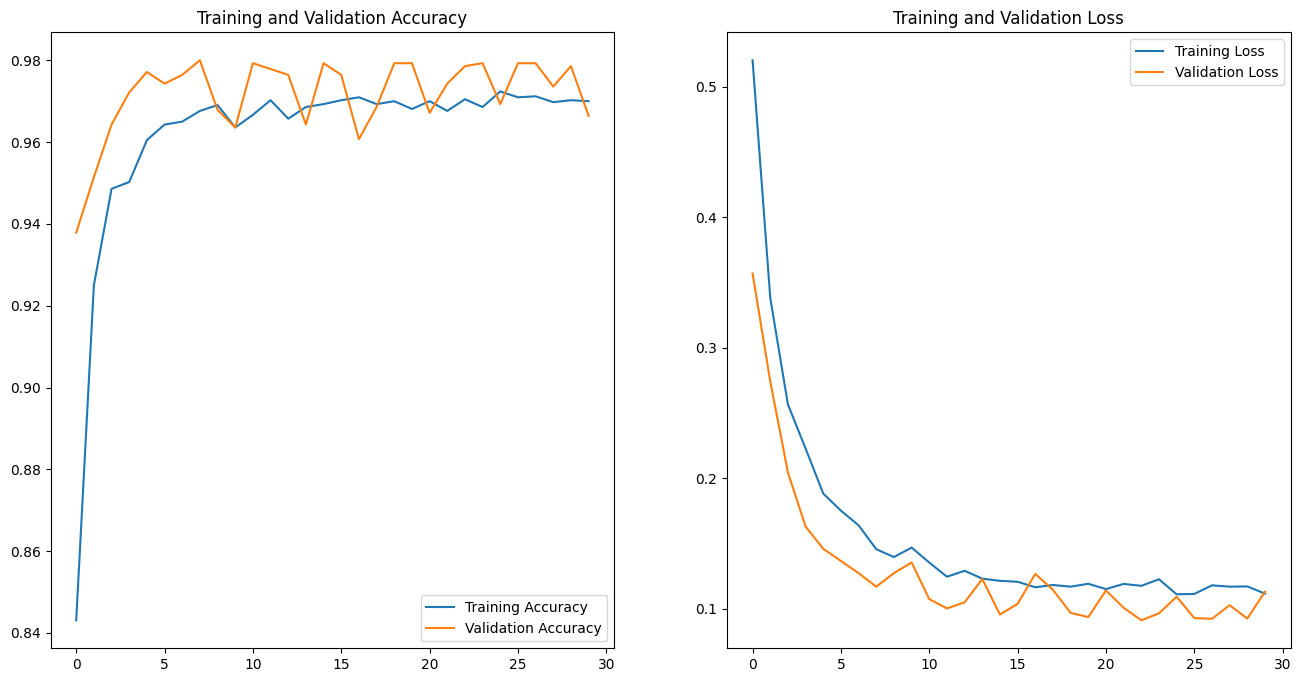

In [23]:
#@title 11. Training & Validation Plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
#@title 12. Model Saving
model_save_path = "/content/drive/MyDrive/pml_clouds_model/model"
model.save(model_save_path)

loaded = tfk.models.load_model(model_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


1/1 [==============================] - 0s 332ms/step
This image most likely has noclouds with a 96.49 percent confidence.
1/1 [==============================] - 0s 193ms/step
This image most likely has noclouds with a 96.49 percent confidence.


(-0.5, 199.5, 199.5, -0.5)

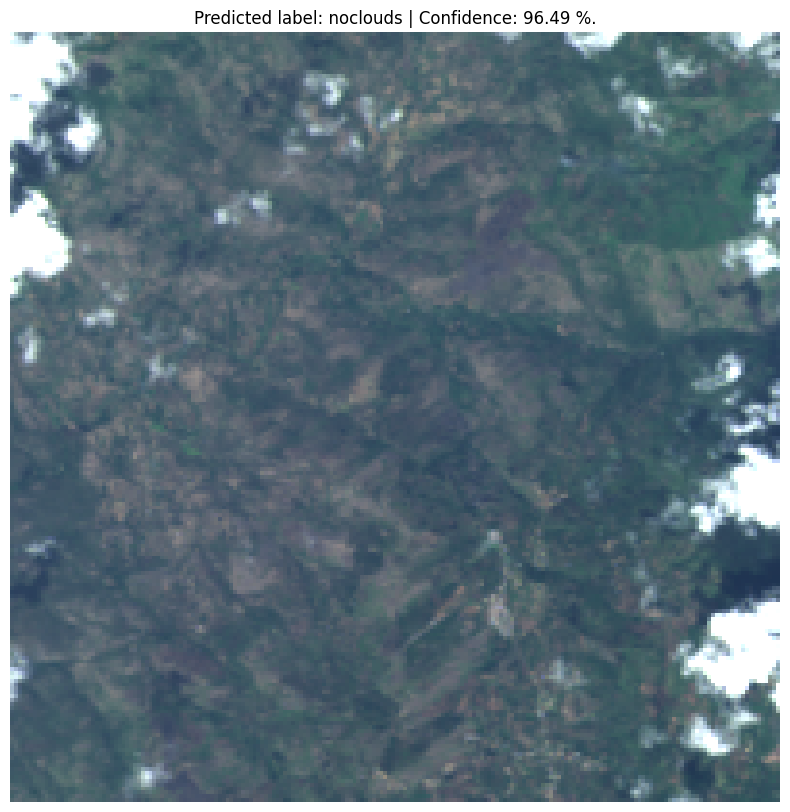

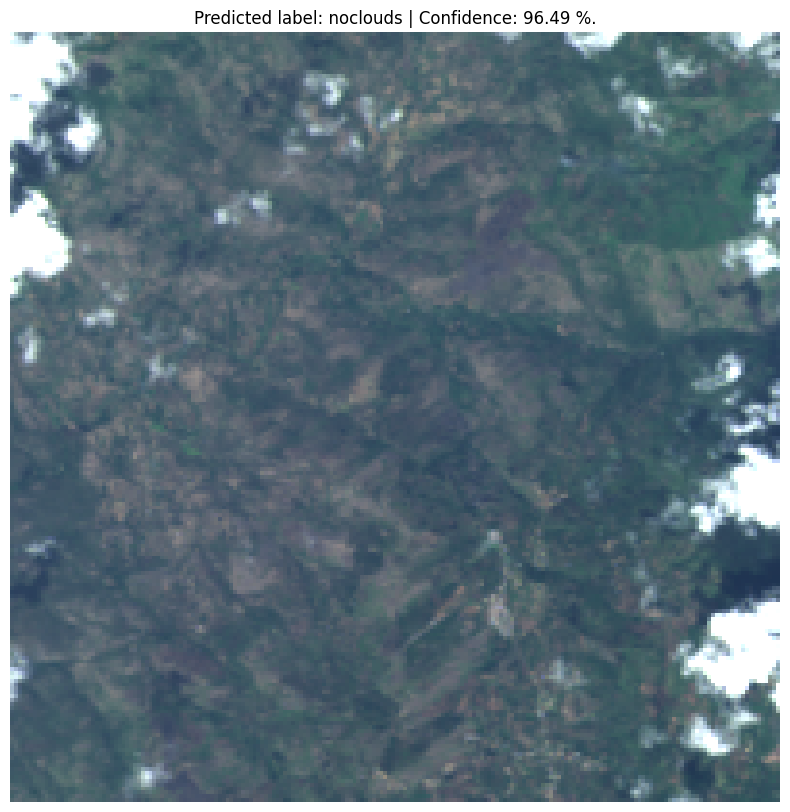

In [25]:
#@title 13. Model Loading & Inference Demonstration
img = tfk.utils.load_img("/content/drive/MyDrive/pml_clouds_task/noclouds/noclouds_14.png", target_size=(img_height, img_width)
)
img_array = tfk.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = loaded.predict(img_array) # Make a prediction
score = tf.nn.softmax(predictions[0]) # Convert from logits to probabilities (sum to unity)

print(
    "This image most likely has {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.figure(figsize=(10, 10))
plt.imshow(img)
label = "Predicted label: {} | Confidence: {:.2f} %.".format(class_names[np.argmax(score)], 100 * np.max(score))
plt.title(label)
plt.axis("off")

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely has {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.figure(figsize=(10, 10))
plt.imshow(img)
label = "Predicted label: {} | Confidence: {:.2f} %.".format(class_names[np.argmax(score)], 100 * np.max(score))
plt.title(label)
plt.axis("off")